## Perturbation of sequences
### Dataset: WIV04 
### Number of sequences = 
### Model: VirProBERT (CoV-S-UniRef90, CoV-S-UniRef90-aligned) 

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/wiv04',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/wiv04/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/wiv04/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/wiv04/..']

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [3]:
human_label = "Human"
perturbation_processed_output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/WIV04/cov-S-binary-aligned-transfer_learning_mlm_fnn_2l_lr1e-4/processed/tl_tf_binary_aligned_sarscov2-S-WIV04ref_aligned.csv_WIV04.csv")

In [4]:
perturbed_output_df = pd.read_csv(perturbation_processed_output_file_path)
print(perturbed_output_df.shape)

(31826, 7)


In [5]:
perturbed_output_df.head()

,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token
0,0.978202,0.021798,WIV04,Human,Y,1876,T
1,0.978202,0.021798,WIV04,Human,H,2413,U
2,0.978254,0.021746,WIV04,Human,G,1102,I
3,0.978202,0.021798,WIV04,Human,S,1741,G
4,0.978202,0.021798,WIV04,Human,P,1619,W


In [6]:
orig_seq_df = perturbed_output_df[perturbed_output_df["orig_token"] == perturbed_output_df["new_token"]]
orig_seq_df

,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token
24230,0.978202,0.021798,WIV04,Human,M,14,M


In [7]:
orig_seq_df_pred = orig_seq_df[human_label].values[0]
orig_seq_df_pred

0.9782023

In [8]:
pred_diff_col = f"{human_label}_pred_diff"
perturbed_output_df[pred_diff_col] = orig_seq_df_pred - perturbed_output_df[human_label]
perturbed_output_df[f"abs_{pred_diff_col}"] = perturbed_output_df[pred_diff_col].abs()
perturbed_output_df.head()

,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
0,0.978202,0.021798,WIV04,Human,Y,1876,T,0.000000,0.000000
1,0.978202,0.021798,WIV04,Human,H,2413,U,0.000000,0.000000
2,0.978254,0.021746,WIV04,Human,G,1102,I,-0.000052,0.000052
3,0.978202,0.021798,WIV04,Human,S,1741,G,0.000000,0.000000
4,0.978202,0.021798,WIV04,Human,P,1619,W,0.000000,0.000000


### Distribution of prediction difference values

/tmp/ipykernel_1134189/2860024834.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(perturbed_output_df["Human_pred_diff"])


<Figure size 432x288 with 0 Axes>

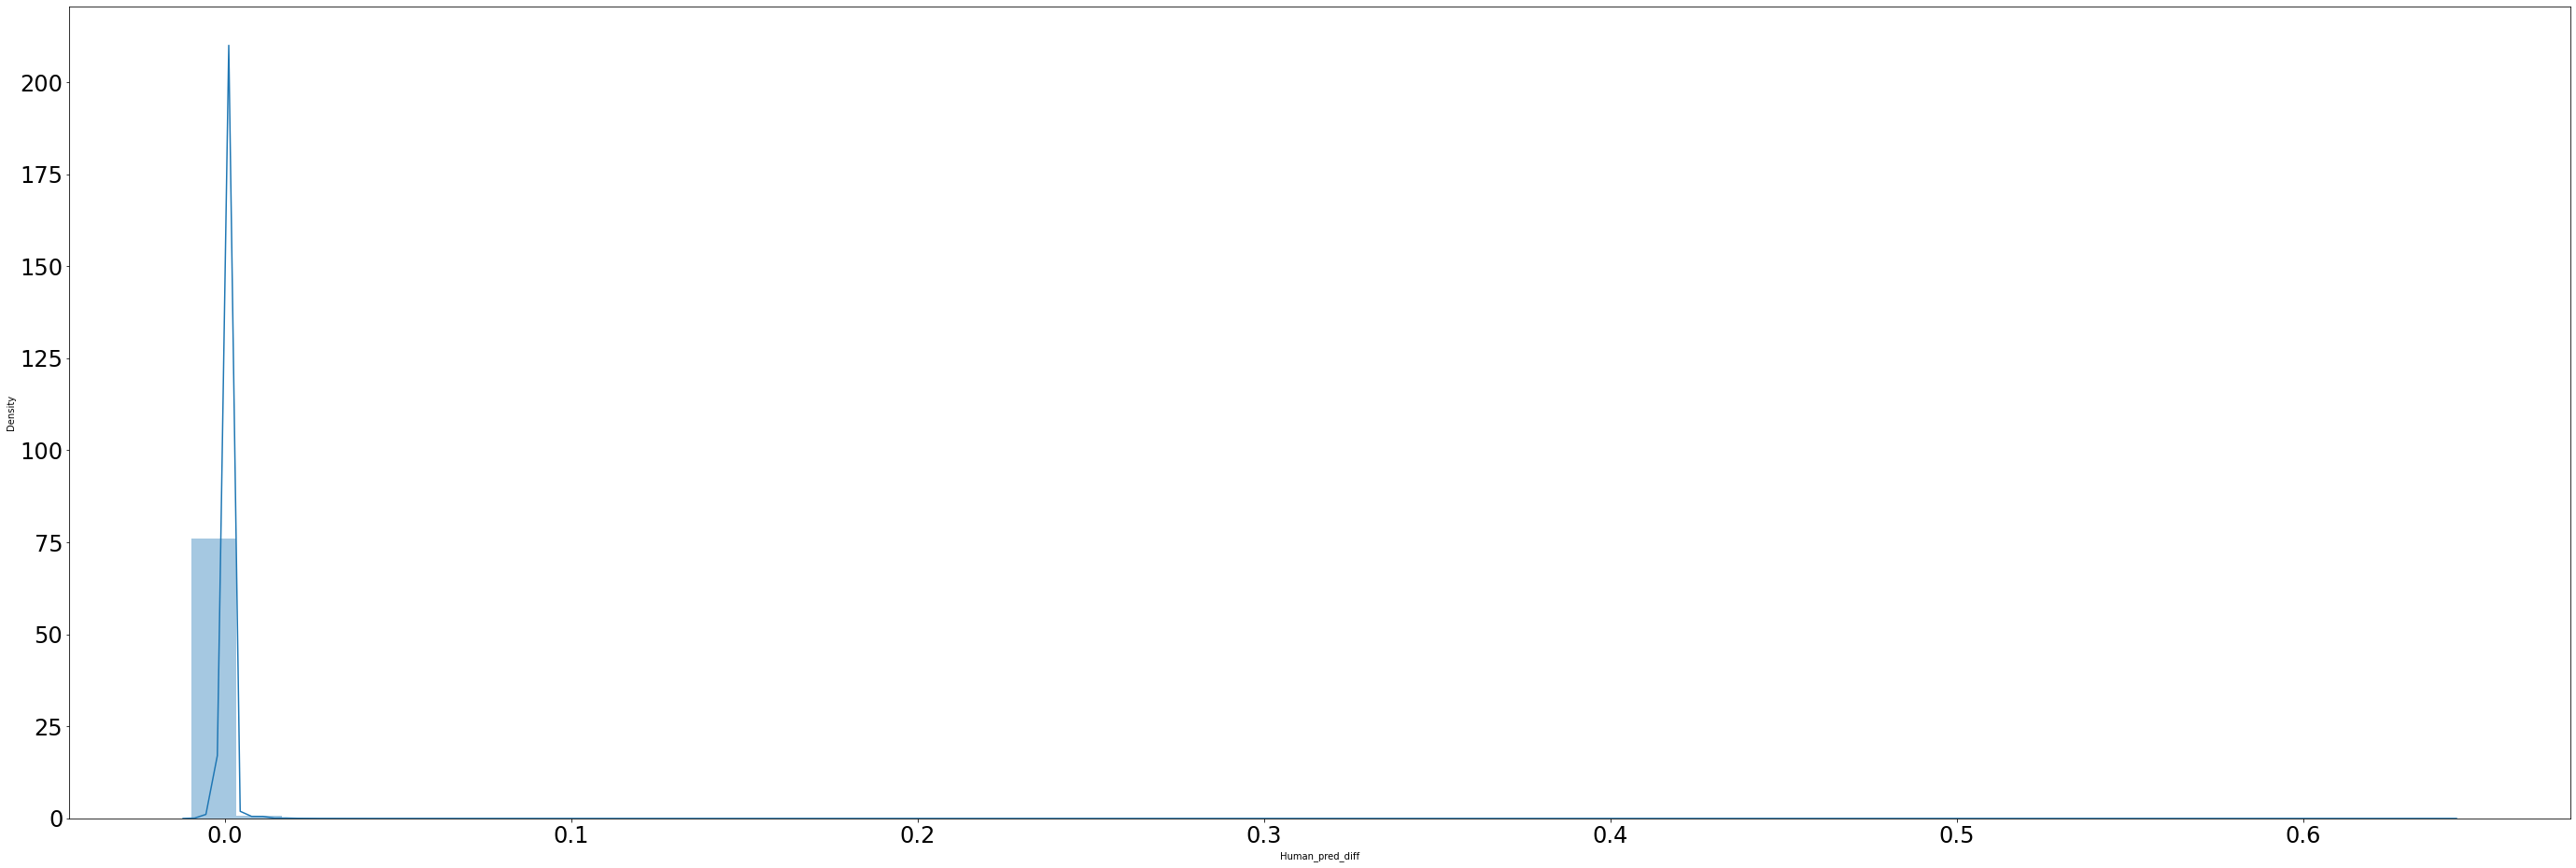

In [9]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
sns.distplot(perturbed_output_df["Human_pred_diff"])
plt.show()

In [10]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})
    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.009756,0.044545,31816,99.968579
1,0.044545,0.098846,4,0.012568
2,0.098846,0.153147,1,0.003142
3,0.153147,0.207449,0,0.000000
4,0.207449,0.261750,1,0.003142
5,0.261750,0.316051,1,0.003142
6,0.316051,0.370352,0,0.000000
7,0.370352,0.424653,0,0.000000
8,0.424653,0.478954,0,0.000000
9,0.478954,0.533255,1,0.003142


### Top 10 perturbations with highest change in prediction probability

In [17]:
perturbed_output_df.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)


,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
16177,0.336345,0.663655,WIV04,Human,V,1068,L,0.641858,0.641858
4414,0.361662,0.638338,WIV04,Human,I,1069,L,0.616540,0.616540
24201,0.458104,0.541896,WIV04,Human,R,1070,L,0.520098,0.520098
19451,0.701638,0.298362,WIV04,Human,Q,1076,L,0.276564,0.276564
6786,0.756403,0.243597,WIV04,Human,L,1243,H,0.221800,0.221800
17965,0.833163,0.166837,WIV04,Human,K,1249,H,0.145039,0.145039
26263,0.879781,0.120219,WIV04,Human,S,1250,H,0.098421,0.098421
30085,0.882739,0.117261,WIV04,Human,Y,1242,H,0.095463,0.095463
22686,0.929037,0.070963,WIV04,Human,R,1248,H,0.049165,0.049165
10164,0.932508,0.067492,WIV04,Human,Y,1244,H,0.045694,0.045694


In [59]:
token_positions = perturbed_output_df["perturb_pos"].unique()
token_positions = [x for x in token_positions]
token_positions.sort()
len(token_positions)

1273

In [60]:
df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values=pred_diff_col)
df[token_positions]

perturb_pos,14,15,16,17,18,19,20,21,22,23,...,2406,2407,2408,2409,2410,2411,2412,2413,2414,2415
new_token,,,,,,,,,,,,,,,,,,,,,
A,0.000344,-0.000030,0.000117,0.000140,0.000297,0.000271,0.000518,0.000740,0.002655,0.000714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,-0.000375,-0.000805,-0.000837,-0.000846,-0.000775,-0.000925,-0.000624,-0.000446,0.000362,-0.000458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,-0.000293,-0.000642,-0.000705,-0.000684,-0.000571,-0.000656,-0.000350,0.000088,0.001423,-0.000079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,-0.000773,-0.001201,-0.001184,-0.001193,-0.001088,-0.001257,-0.001051,-0.000929,-0.000481,-0.000767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,-0.000733,-0.001173,-0.001118,-0.001117,-0.001024,-0.001285,-0.001102,-0.001001,-0.000656,-0.000854,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.000292,NaN,-0.000084,NaN,0.000043,0.000063,0.000181,0.000245,0.002738,0.000046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,-0.000596,-0.000970,-0.000870,-0.000838,-0.000721,-0.000809,-0.000499,-0.000232,0.001314,-0.000205,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
H,-0.000430,-0.000860,-0.000936,-0.000830,-0.000700,-0.000996,-0.000748,-0.000646,-0.000076,-0.000557,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
I,0.000162,-0.000091,-0.000004,-0.000100,0.000038,-0.000014,0.000203,0.000388,0.002542,0.000140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 432x288 with 0 Axes>

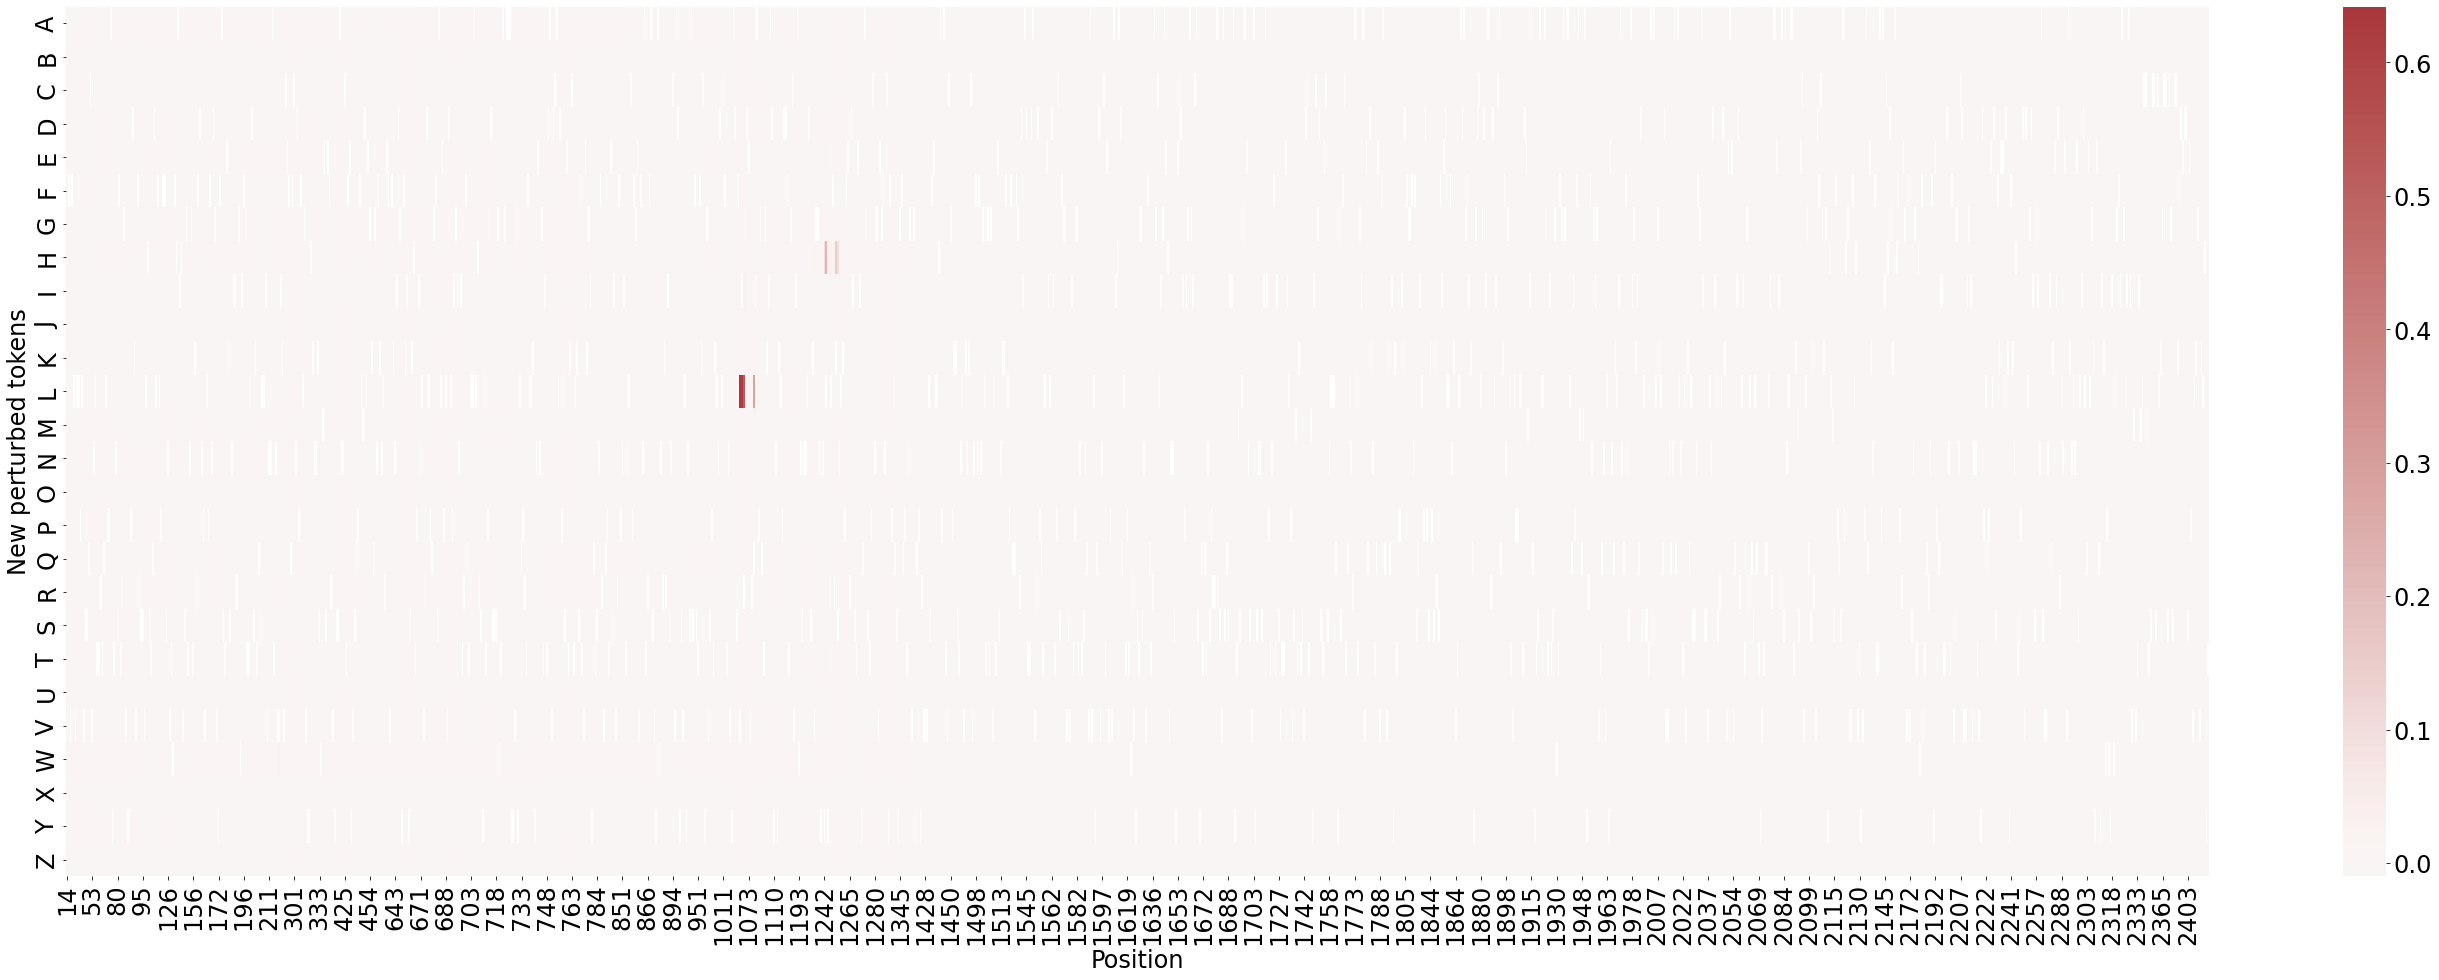

In [61]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['figure.autolayout'] = True
ax = sns.heatmap(df, cmap=cmap, center=0)
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
plt.show()

In [62]:
df.mean(axis=0)

perturb_pos
14      0.000018
15     -0.000386
16     -0.000513
17     -0.000663
18     -0.000585
          ...   
2411    0.000000
2412    0.000000
2413    0.000000
2414    0.000000
2415    0.000000
Length: 1273, dtype: float64

<Figure size 432x288 with 0 Axes>

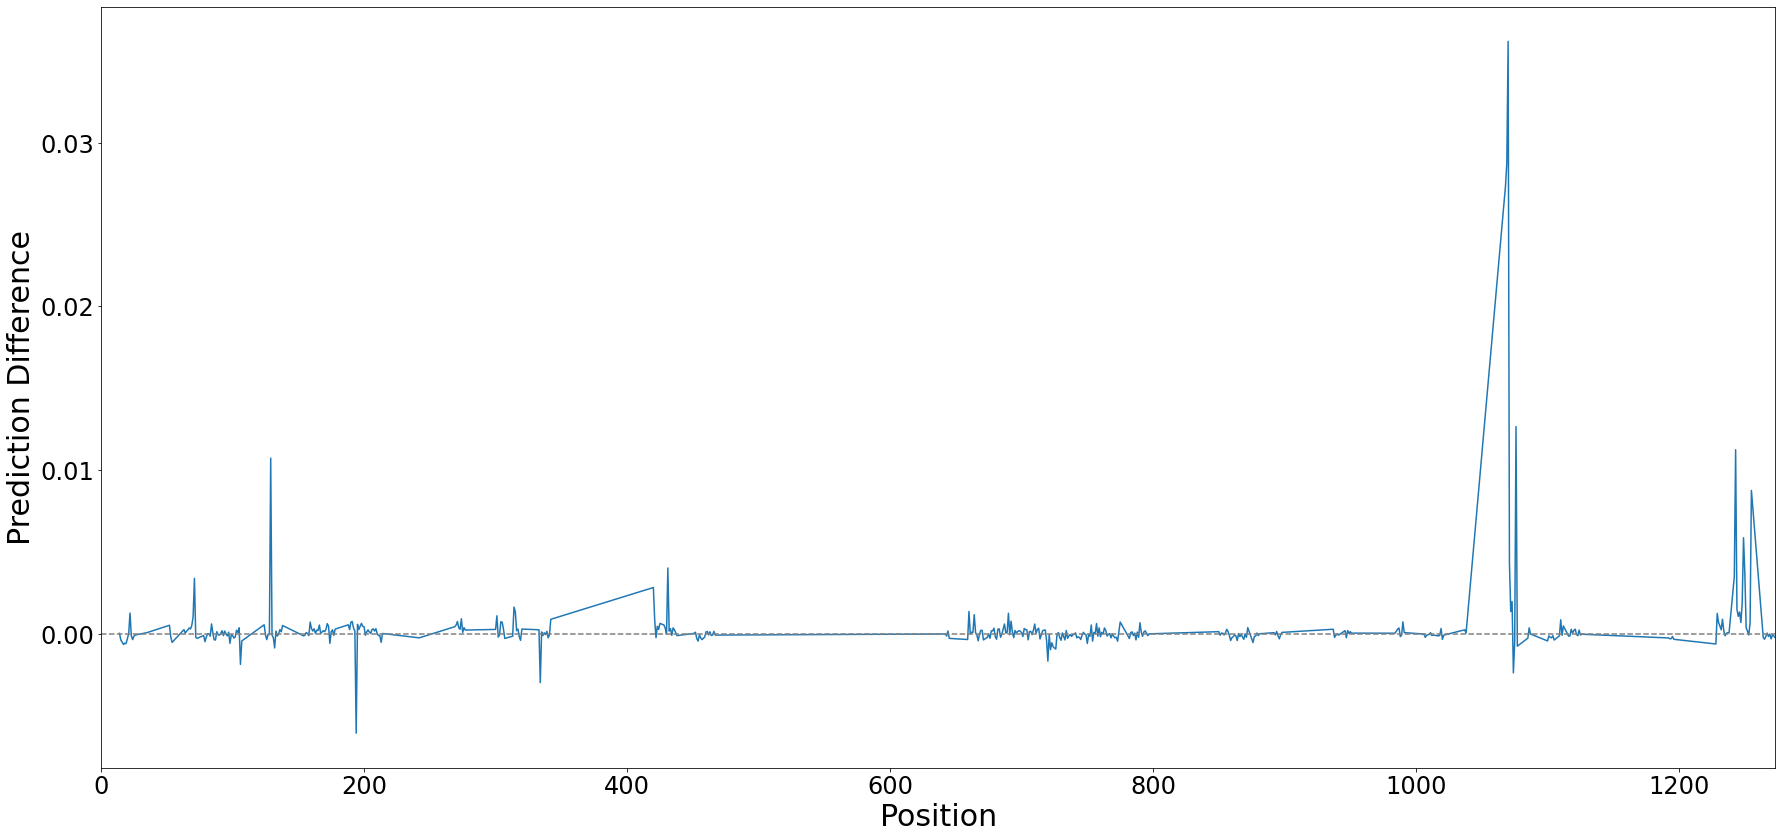

In [63]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
ax.axhline(0.0, color="gray", linestyle="--")
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.xlabel('Position', fontsize=30)
plt.ylabel('Prediction Difference', fontsize=30)
ax.set_xlim(0, 1273)
plt.show()